In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/WSN-Project/

Mounted at /content/drive
/content/drive/My Drive/WSN-Project


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.3 MB/s eta 0:00:00


In [27]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sbn
from  sklearn import metrics as m
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SVMSMOTE,RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

In [4]:
df = pd.read_csv("WSN-DS.csv")

In [5]:
df.head(5)

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Attack type
0,101000,50,1,101000,0.00000,1,0,0,25,1,0,0,0,1200,48,130.08535,0,2.46940,Normal
1,101001,50,0,101044,75.32345,0,4,1,0,0,1,2,38,0,0,0.00000,4,0.06957,Normal
2,101002,50,0,101010,46.95453,0,4,1,0,0,1,19,41,0,0,0.00000,3,0.06898,Normal
3,101003,50,0,101044,64.85231,0,4,1,0,0,1,16,38,0,0,0.00000,4,0.06673,Normal
4,101004,50,0,101010,4.83341,0,4,1,0,0,1,25,41,0,0,0.00000,3,0.06534,Normal


In [6]:
df.shape

(374661, 19)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374661 entries, 0 to 374660
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0    id               374661 non-null  int64  
 1    Time             374661 non-null  int64  
 2    Is_CH            374661 non-null  int64  
 3    who CH           374661 non-null  int64  
 4    Dist_To_CH       374661 non-null  float64
 5    ADV_S            374661 non-null  int64  
 6    ADV_R            374661 non-null  int64  
 7    JOIN_S           374661 non-null  int64  
 8    JOIN_R           374661 non-null  int64  
 9    SCH_S            374661 non-null  int64  
 10   SCH_R            374661 non-null  int64  
 11  Rank              374661 non-null  int64  
 12   DATA_S           374661 non-null  int64  
 13   DATA_R           374661 non-null  int64  
 14   Data_Sent_To_BS  374661 non-null  int64  
 15   dist_CH_To_BS    374661 non-null  float64
 16   send_code        37

In [8]:
df.value_counts("Attack type")

Attack type
Normal       340066
Grayhole      14596
Blackhole     10049
TDMA           6638
Flooding       3312
dtype: int64

In [9]:
df["Attack type"].to_numpy()
category=[]
for i in df["Attack type"]:
  if "Normal" in i:
    category.append("Normal")
  else:
    category.append("DoS")
df["Class"]=category

In [10]:
df.value_counts("Class")

Class
Normal    340066
DoS        34595
dtype: int64

In [11]:
df = df.drop_duplicates()

In [12]:
df = df.drop([' id',' Time',' who CH', 'Attack type'], axis=1)
df.head(5)

,Is_CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Class
0,1,0.00000,1,0,0,25,1,0,0,0,1200,48,130.08535,0,2.46940,Normal
1,0,75.32345,0,4,1,0,0,1,2,38,0,0,0.00000,4,0.06957,Normal
2,0,46.95453,0,4,1,0,0,1,19,41,0,0,0.00000,3,0.06898,Normal
3,0,64.85231,0,4,1,0,0,1,16,38,0,0,0.00000,4,0.06673,Normal
4,0,4.83341,0,4,1,0,0,1,25,41,0,0,0.00000,3,0.06534,Normal


In [13]:
df["Class"]=df.Class.map({"DoS": 1, "Normal": 0})

In [14]:
df.value_counts("Class")

Class
0    332040
1     33748
dtype: int64

[Text(0.5, 1.0, 'Dengelenmemiş Veri Seti'), Text(0.5, 0, 'Class')]

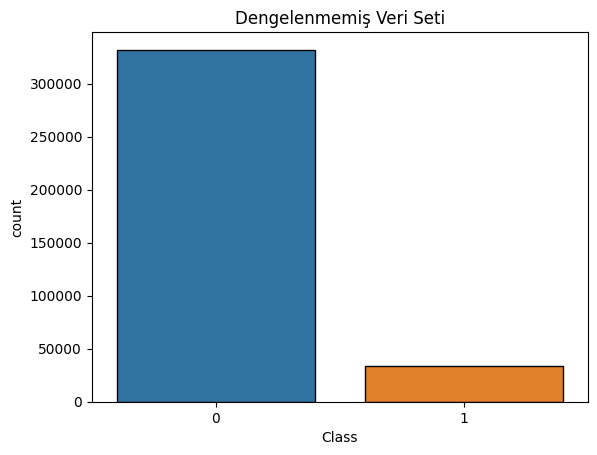

In [15]:
sbn.countplot(x="Class", data = df,  edgecolor = "black").set(title='Dengelenmemiş Veri Seti',xlabel="Class")


In [16]:
X = df.iloc[:,0:-1].values # bağımsız değişkenler
y = df.iloc[:,-1].values # bağımlı değişken

In [17]:
scaler = sk.preprocessing.Normalizer()
X = scaler.fit_transform(X)

In [18]:
print(X.shape)
print(y.shape)

(365788, 15)
(365788,)


In [19]:
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(X, y, test_size=0.3, random_state=8)

In [20]:
lr = LogisticRegression(random_state= 8, max_iter=100)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)
acc_lr = m.accuracy_score(y_val, y_pred_lr)
f1_lr = m.f1_score(y_val, y_pred_lr)
pre_lr = m.precision_score(y_val, y_pred_lr)
rec_lr = m.recall_score(y_val, y_pred_lr)
print("accuracy: ", acc_lr)
print("f1 score: ",f1_lr)
print("precision: ", pre_lr)
print("recall: ", rec_lr)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy:  0.9702561579048088
f1 score:  0.8328211432083589
precision:  0.8644338118022329
recall:  0.8034390750074119


In [21]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import classification_report
target_names = ['Normal', "DoS"]
print(classification_report(y_val, y_pred_lr, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98     99618
         DoS       0.86      0.80      0.83     10119

    accuracy                           0.97    109737
   macro avg       0.92      0.90      0.91    109737
weighted avg       0.97      0.97      0.97    109737



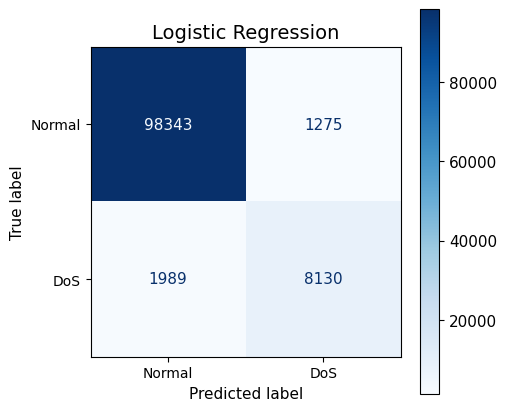

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_pred_lr)
cmp = ConfusionMatrixDisplay(cm, display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('Logistic Regression', fontdict = {'fontsize': 14})
ax.set_xlabel('Predicted Label', fontdict = {'fontsize': 11})
ax.set_ylabel('True Label', fontdict = {'fontsize': 11})
plt.rcParams.update({'font.size': 11})
cmp.plot(ax=ax, cmap=plt.cm.Blues, values_format="")
plt.show()

In [23]:
dt = DecisionTreeClassifier(random_state= 8, max_depth=10)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_val)
acc_dt = accuracy_score(y_val, y_pred_dt)
f1_dt = f1_score(y_val, y_pred_dt)
pre_dt = precision_score(y_val, y_pred_dt)
rec_dt = recall_score(y_val, y_pred_dt)
print("accuracy: ", acc_dt)
print("f1 score: ",f1_dt)
print("precision: ", pre_dt)
print("recall: ", rec_dt)


accuracy:  0.9958719483856858
f1 score:  0.9775997626464917
precision:  0.9783254156769596
recall:  0.9768751852949896


In [24]:
from sklearn.metrics import classification_report
target_names = ['Normal', "DoS"]
print(classification_report(y_val, y_pred_dt, target_names=target_names))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     99618
         DoS       0.98      0.98      0.98     10119

    accuracy                           1.00    109737
   macro avg       0.99      0.99      0.99    109737
weighted avg       1.00      1.00      1.00    109737



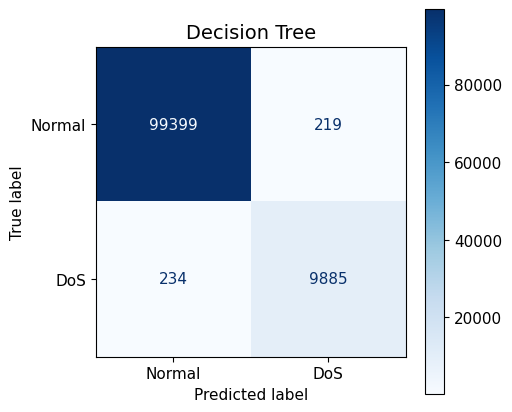

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_pred_dt)
cmp = ConfusionMatrixDisplay(cm, display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('Decision Tree', fontdict = {'fontsize': 14})
ax.set_xlabel('Predicted Label', fontdict = {'fontsize': 11})
ax.set_ylabel('True Label', fontdict = {'fontsize': 11})
plt.rcParams.update({'font.size': 11})
cmp.plot(ax=ax, cmap=plt.cm.Blues, values_format="")
plt.show()

In [28]:
gnb = BernoulliNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_val)
acc_gnb = m.accuracy_score(y_val, y_pred_gnb)
f1_gnb = m.f1_score(y_val, y_pred_gnb)
pre_gnb = m.precision_score(y_val, y_pred_gnb)
rec_gnb = m.recall_score(y_val, y_pred_gnb)
print("accuracy: ", acc_gnb)
print("f1 score: ",f1_gnb)
print("precision: ", pre_gnb)
print("recall: ", rec_gnb)


accuracy:  0.9739103492896652
f1 score:  0.8746991115584928
precision:  0.7849960722702278
recall:  0.9875481766973021


In [29]:
from sklearn.metrics import classification_report
target_names = ['Normal', "DoS"]
print(classification_report(y_val, y_pred_gnb, target_names=target_names))

              precision    recall  f1-score   support

      Normal       1.00      0.97      0.99     99618
         DoS       0.78      0.99      0.87     10119

    accuracy                           0.97    109737
   macro avg       0.89      0.98      0.93    109737
weighted avg       0.98      0.97      0.98    109737



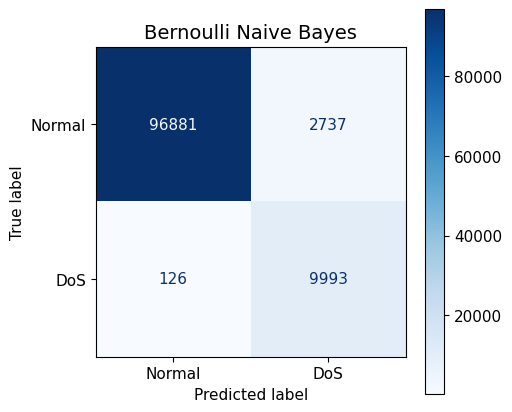

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_pred_gnb)
cmp = ConfusionMatrixDisplay(cm, display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('Bernoulli Naive Bayes', fontdict = {'fontsize': 14})
ax.set_xlabel('Predicted Label', fontdict = {'fontsize': 11})
ax.set_ylabel('True Label', fontdict = {'fontsize': 11})
plt.rcParams.update({'font.size': 11})
cmp.plot(ax=ax, cmap=plt.cm.Blues, values_format="")
plt.show()

In [31]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)
y_pred_knn1 = knn1.predict(X_val)
acc_knn1 = accuracy_score(y_val, y_pred_knn1)
f1_knn1 = f1_score(y_val, y_pred_knn1)
pre_knn1 = precision_score(y_val, y_pred_knn1)
rec_knn1 = recall_score(y_val, y_pred_knn1)
print("accuracy: ", acc_knn1)
print("f1 score: ",f1_knn1)
print("precision: ", pre_knn1)
print("recall: ", rec_knn1)


accuracy:  0.993201928246626
f1 score:  0.963072963072963
precision:  0.9647922245363483
recall:  0.9613598181638502


In [32]:
from sklearn.metrics import classification_report
target_names = ['Normal', "DoS"]
print(classification_report(y_val, y_pred_knn1, target_names=target_names))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     99618
         DoS       0.96      0.96      0.96     10119

    accuracy                           0.99    109737
   macro avg       0.98      0.98      0.98    109737
weighted avg       0.99      0.99      0.99    109737



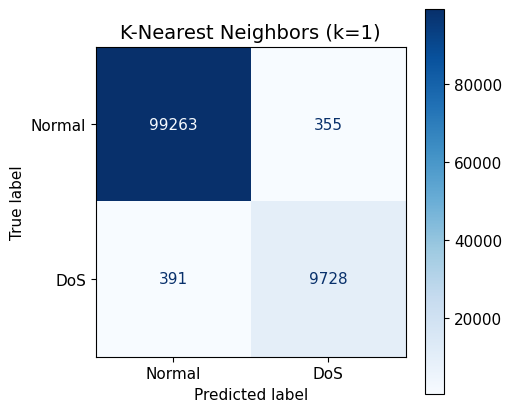

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_pred_knn1)
cmp = ConfusionMatrixDisplay(cm, display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('K-Nearest Neighbors (k=1)', fontdict = {'fontsize': 14})
ax.set_xlabel('Predicted Label', fontdict = {'fontsize': 11})
ax.set_ylabel('True Label', fontdict = {'fontsize': 11})
plt.rcParams.update({'font.size': 11})
cmp.plot(ax=ax, cmap=plt.cm.Blues, values_format="")
plt.show()

In [34]:
knn2 = KNeighborsClassifier(n_neighbors=3)
knn2.fit(X_train, y_train)
y_pred_knn2 = knn2.predict(X_val)
acc_knn2 = accuracy_score(y_val, y_pred_knn2)
f1_knn2 = f1_score(y_val, y_pred_knn2)
pre_knn2 = precision_score(y_val, y_pred_knn2)
rec_knn2 = recall_score(y_val, y_pred_knn2)
print("accuracy: ", acc_knn2)
print("f1 score: ",f1_knn2)
print("precision: ", pre_knn2)
print("recall: ", rec_knn2)


accuracy:  0.9947510866890839
f1 score:  0.9713803040842691
precision:  0.976816228639952
recall:  0.9660045459037454


In [35]:
from sklearn.metrics import classification_report
target_names = ['Normal', "DoS"]
print(classification_report(y_val, y_pred_knn2, target_names=target_names))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     99618
         DoS       0.98      0.97      0.97     10119

    accuracy                           0.99    109737
   macro avg       0.99      0.98      0.98    109737
weighted avg       0.99      0.99      0.99    109737



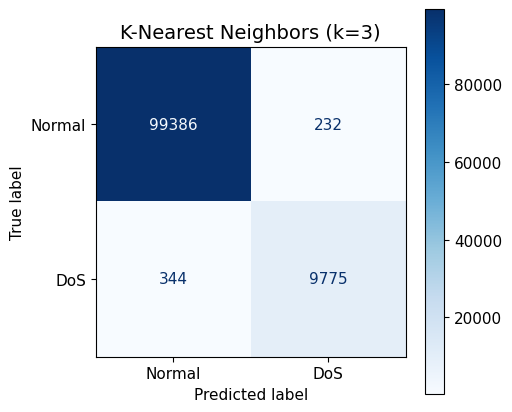

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_pred_knn2)
cmp = ConfusionMatrixDisplay(cm, display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('K-Nearest Neighbors (k=3)', fontdict = {'fontsize': 14})
ax.set_xlabel('Predicted Label', fontdict = {'fontsize': 11})
ax.set_ylabel('True Label', fontdict = {'fontsize': 11})
plt.rcParams.update({'font.size': 11})
cmp.plot(ax=ax, cmap=plt.cm.Blues, values_format="")
plt.show()

In [37]:
knn3 = KNeighborsClassifier(n_neighbors=5)
knn3.fit(X_train, y_train)
y_pred_knn3 = knn3.predict(X_val)
acc_knn3 = accuracy_score(y_val, y_pred_knn3)
f1_knn3 = f1_score(y_val, y_pred_knn3)
pre_knn3 = precision_score(y_val, y_pred_knn3)
rec_knn3 = recall_score(y_val, y_pred_knn3)
print("accuracy: ", acc_knn3)
print("f1 score: ",f1_knn3)
print("precision: ", pre_knn3)
print("recall: ", rec_knn3)


accuracy:  0.9945870581481178
f1 score:  0.9704918032786884
precision:  0.9757267006293078
recall:  0.9653127779424845


In [38]:
from sklearn.metrics import classification_report
target_names = ['Normal', "DoS"]
print(classification_report(y_val, y_pred_knn3, target_names=target_names))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     99618
         DoS       0.98      0.97      0.97     10119

    accuracy                           0.99    109737
   macro avg       0.99      0.98      0.98    109737
weighted avg       0.99      0.99      0.99    109737



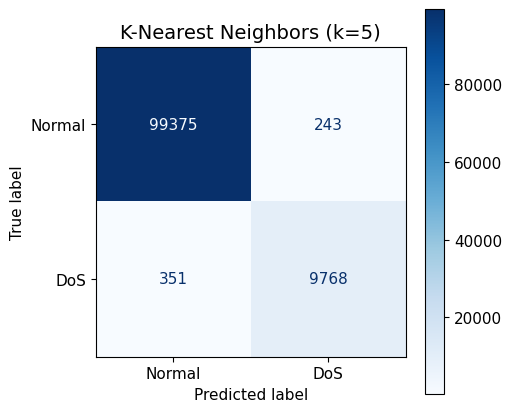

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_pred_knn3)
cmp = ConfusionMatrixDisplay(cm, display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('K-Nearest Neighbors (k=5)', fontdict = {'fontsize': 14})
ax.set_xlabel('Predicted Label', fontdict = {'fontsize': 11})
ax.set_ylabel('True Label', fontdict = {'fontsize': 11})
plt.rcParams.update({'font.size': 11})
cmp.plot(ax=ax, cmap=plt.cm.Blues, values_format="")
plt.show()

In [40]:
ada = AdaBoostClassifier(n_estimators=100,learning_rate=0.01,  random_state=8)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_val)
acc_ada= accuracy_score(y_val, y_pred_ada)
f1_ada = f1_score(y_val, y_pred_ada)
pre_ada = precision_score(y_val, y_pred_ada)
rec_ada = recall_score(y_val, y_pred_ada)
print("accuracy: ", acc_ada)
print("f1 score: ",f1_ada)
print("precision: ", pre_ada)
print("recall: ", rec_ada)

accuracy:  0.973928574683106
f1 score:  0.8747756817087583
precision:  0.7851194217473287
recall:  0.9875481766973021


In [41]:
from sklearn.metrics import classification_report
target_names = ['Normal', "DoS"]
print(classification_report(y_val, y_pred_ada, target_names=target_names))

              precision    recall  f1-score   support

      Normal       1.00      0.97      0.99     99618
         DoS       0.79      0.99      0.87     10119

    accuracy                           0.97    109737
   macro avg       0.89      0.98      0.93    109737
weighted avg       0.98      0.97      0.98    109737



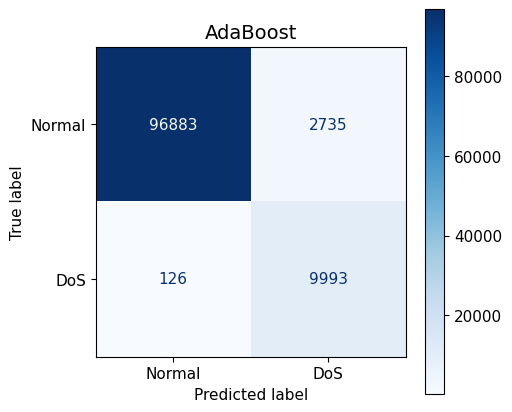

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_pred_ada)
cmp = ConfusionMatrixDisplay(cm, display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('AdaBoost', fontdict = {'fontsize': 14})
ax.set_xlabel('Predicted Label', fontdict = {'fontsize': 11})
ax.set_ylabel('True Label', fontdict = {'fontsize': 11})
plt.rcParams.update({'font.size': 11})
cmp.plot(ax=ax, cmap=plt.cm.Blues, values_format="")
plt.show()

In [43]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,  random_state=8)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_val)
acc_gb= accuracy_score(y_val, y_pred_gb)
f1_gb = f1_score(y_val, y_pred_gb)
pre_gb = precision_score(y_val, y_pred_gb)
rec_gb = recall_score(y_val, y_pred_gb)
print("accuracy: ", acc_gb)
print("f1 score: ",f1_gb)
print("precision: ", pre_gb)
print("recall: ", rec_gb)

accuracy:  0.9855837137884214
f1 score:  0.9167193093282796
precision:  0.980849386053847
recall:  0.8604605198142109


In [44]:
from sklearn.metrics import classification_report
target_names = ['Normal', "DoS"]
print(classification_report(y_val, y_pred_gb, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99     99618
         DoS       0.98      0.86      0.92     10119

    accuracy                           0.99    109737
   macro avg       0.98      0.93      0.95    109737
weighted avg       0.99      0.99      0.99    109737



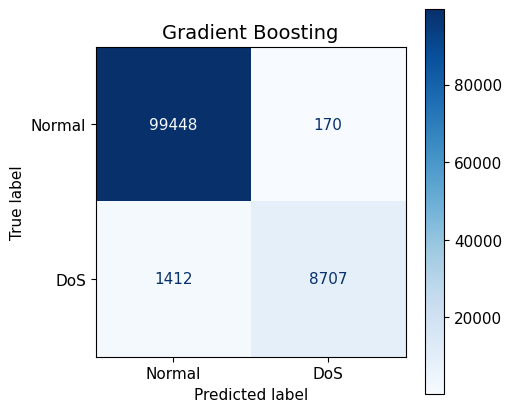

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_pred_gb)
cmp = ConfusionMatrixDisplay(cm, display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('Gradient Boosting', fontdict = {'fontsize': 14})
ax.set_xlabel('Predicted Label', fontdict = {'fontsize': 11})
ax.set_ylabel('True Label', fontdict = {'fontsize': 11})
plt.rcParams.update({'font.size': 11})
cmp.plot(ax=ax, cmap=plt.cm.Blues, values_format="")
plt.show()

In [46]:
cb= CatBoostClassifier(iterations=100, learning_rate=0.01, random_seed=8)
cb.fit(X_train, y_train)
y_pred_cb = cb.predict(X_val)
acc_cb= accuracy_score(y_val, y_pred_cb)
f1_cb = f1_score(y_val, y_pred_cb)
pre_cb = precision_score(y_val, y_pred_cb)
rec_cb = recall_score(y_val, y_pred_cb)
print("accuracy: ", acc_cb)
print("f1 score: ",f1_cb)
print("precision: ", pre_cb)
print("recall: ", rec_cb)

0:	learn: 0.6838154	total: 90ms	remaining: 8.91s
1:	learn: 0.6744433	total: 125ms	remaining: 6.12s
2:	learn: 0.6651710	total: 158ms	remaining: 5.1s
3:	learn: 0.6559758	total: 194ms	remaining: 4.65s
4:	learn: 0.6472269	total: 227ms	remaining: 4.32s
5:	learn: 0.6387420	total: 264ms	remaining: 4.14s
6:	learn: 0.6300509	total: 311ms	remaining: 4.13s
7:	learn: 0.6217516	total: 350ms	remaining: 4.03s
8:	learn: 0.6134215	total: 384ms	remaining: 3.88s
9:	learn: 0.6052696	total: 420ms	remaining: 3.78s
10:	learn: 0.5974218	total: 454ms	remaining: 3.67s
11:	learn: 0.5898342	total: 487ms	remaining: 3.57s
12:	learn: 0.5822246	total: 532ms	remaining: 3.56s
13:	learn: 0.5747221	total: 566ms	remaining: 3.47s
14:	learn: 0.5672419	total: 599ms	remaining: 3.39s
15:	learn: 0.5599274	total: 633ms	remaining: 3.32s
16:	learn: 0.5530338	total: 669ms	remaining: 3.27s
17:	learn: 0.5459232	total: 703ms	remaining: 3.2s
18:	learn: 0.5391073	total: 741ms	remaining: 3.16s
19:	learn: 0.5324167	total: 778ms	remaining:

In [47]:
from sklearn.metrics import classification_report
target_names = ['Normal', 'DoS']
print(classification_report(y_val, y_pred_cb, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00     99618
         DoS       0.96      0.94      0.95     10119

    accuracy                           0.99    109737
   macro avg       0.98      0.97      0.97    109737
weighted avg       0.99      0.99      0.99    109737



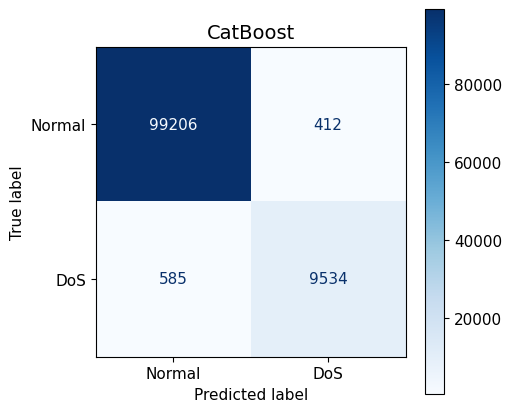

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_val, y_pred_cb)
cmp = ConfusionMatrixDisplay(cm, display_labels=target_names)
fig, ax, = plt.subplots(figsize=(5,5))
ax.set_title('CatBoost', fontdict = {'fontsize': 14})
ax.set_xlabel('Predicted Label', fontdict = {'fontsize': 11})
ax.set_ylabel('True Label', fontdict = {'fontsize': 11})
plt.rcParams.update({'font.size': 11})
cmp.plot(ax=ax, cmap=plt.cm.Blues, values_format="")
plt.show()

In [49]:
from sklearn.metrics import RocCurveDisplay

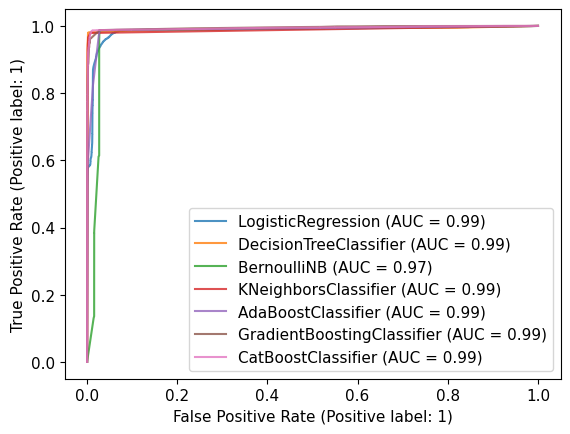

In [53]:
ax = plt.gca()
lr_disp = RocCurveDisplay.from_estimator(lr, X_val, y_val,ax=ax,  alpha=0.8)
dt_disp = RocCurveDisplay.from_estimator(dt, X_val, y_val,ax=ax, alpha=0.8)
gnb_disp = RocCurveDisplay.from_estimator(gnb, X_val, y_val,ax=ax,  alpha=0.8)
knn2_disp = RocCurveDisplay.from_estimator(knn2, X_val, y_val,ax=ax,  alpha=0.8)
ada_disp = RocCurveDisplay.from_estimator(ada, X_val, y_val,ax=ax, alpha=0.8)
gb_disp = RocCurveDisplay.from_estimator(gb, X_val, y_val,ax=ax,  alpha=0.8)
cb_disp = RocCurveDisplay.from_estimator(cb, X_val, y_val,ax=ax,  alpha=0.8)
plt.show()

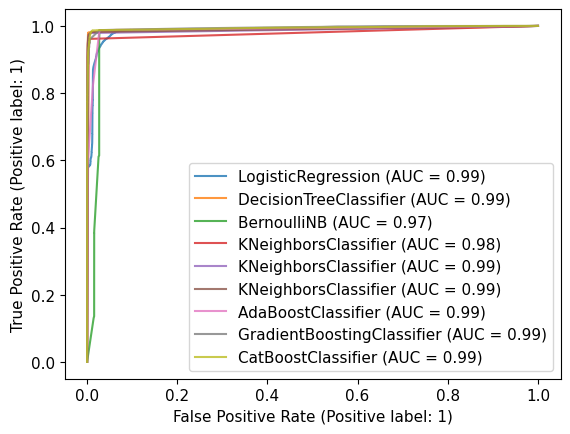

In [51]:
ax = plt.gca()
lr_disp = RocCurveDisplay.from_estimator(lr, X_val, y_val, ax=ax, alpha=0.8)
dt_disp = RocCurveDisplay.from_estimator(dt, X_val, y_val, ax=ax, alpha=0.8)
gnb_disp = RocCurveDisplay.from_estimator(gnb, X_val, y_val, ax=ax, alpha=0.8)
knn1_disp = RocCurveDisplay.from_estimator(knn1, X_val, y_val, ax=ax, alpha=0.8)
knn2_disp = RocCurveDisplay.from_estimator(knn2, X_val, y_val, ax=ax, alpha=0.8)
knn3_disp = RocCurveDisplay.from_estimator(knn3, X_val, y_val, ax=ax, alpha=0.8)
ada_disp = RocCurveDisplay.from_estimator(ada, X_val, y_val, ax=ax, alpha=0.8)
gb_disp = RocCurveDisplay.from_estimator(gb, X_val, y_val, ax=ax, alpha=0.8)
cb_disp = RocCurveDisplay.from_estimator(cb, X_val, y_val, ax=ax, alpha=0.8)
plt.show()